In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
import sys
sys.path.append("..")

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from util import plot_grid, plot_images

In [29]:
from gaussianprocess.gp import sample_rbe_gp, gaussian_process_posterior, grid_distances, rbe_kernel
from skimage.restoration import denoise_nl_means, estimate_sigma

In [30]:
dir = '../figs/theory/'

In [31]:
def expand(x, r):
    return np.repeat(np.repeat(x, r, axis = 0), r, axis = 1)

# Example Inferences

In [32]:
from gaussianprocess.gp import GPDataset

In [33]:
size = 21
N = size*size
n_samples = 2
noise_std = 0.5

In [34]:
length_scale = 1.0

np.random.seed(1)
data = GPDataset(size, length_scale, n_samples, noise_std, torus=True)
y_from_x = data.conv_denoise()
y_from_x_mask = data.conv_denoise_mask()
y_from_y_mask = data.conv_denoise_mask(noise=False)
vmax = np.abs(data.X[0]).max()
vmin = -vmax

In [35]:
for length_scale in [1, 2, 3]:

    np.random.seed(1)
    data = GPDataset(size, length_scale, n_samples, noise_std, torus=True)
    y_from_x = data.conv_denoise()
    y_from_x_mask = data.conv_denoise_mask()
    y_from_y_mask = data.conv_denoise_mask(noise=False)
    vmax = np.abs(data.X[0]).max()
    vmin = -vmax
    
    plt.imsave(dir + 'gp_' + str(length_scale) + '_clean.png', 
               expand(data.Y[0], 3), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.imsave(dir + 'gp_' + str(length_scale) + '_noisy.png', 
               expand(data.X[0], 3), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.imsave(dir + 'gp_' + str(length_scale) + '_optimal.png', 
               expand(y_from_x[0], 3), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.imsave(dir + 'gp_' + str(length_scale) + '_optimal_independent.png', 
               expand(y_from_x_mask[0], 3), cmap = 'magma', vmin = vmin, vmax = vmax)

../gaussianprocess/gp.py:95: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(np.zeros(N), self.K, size=samples)


# Analytical expected MSE

In [36]:
def posterior_variance(K, L, fast = True):
    center = len(K)//2
    return K[center, center] - K[center].dot(np.linalg.solve(K + L, K[:,center]))

In [37]:
def posterior_variance_masked(K, L=0):
    center = len(K)//2
    obs = (np.arange(len(K)) != center)
    K_y = K + L
    K_y_obs = K_y[obs,:][:, obs]

    Sigma_obs_center = K[center, center] - np.dot(K[center,obs], np.linalg.solve(K_y_obs, K[obs,center]))
    return Sigma_obs_center

In [38]:
length_scales = np.linspace(0.75, 3.5, 12, endpoint = False)
noise_stds = np.linspace(0.1, 2.1, 10, endpoint = False)
noise_stds = [0.5, 1.0, 1.5]

results = {}

for noise_std in noise_stds:
    expected_mse = []
    expected_mse_masked = []
    expected_mse_masked_gt = []
    for length_scale in length_scales:
        radius = length_scale*np.sqrt(-2*np.log(1e-8))
        size = int(max(2*radius, 32))
        N = size*size
        D = grid_distances(size, torus=True)

        K = rbe_kernel(D, length_scale, 1).reshape(N, N)
        L = np.eye(N) * noise_std ** 2
        
        expected_mse.append(posterior_variance(K, L))
        expected_mse_masked.append(posterior_variance_masked(K, L))
        expected_mse_masked_gt.append(posterior_variance_masked(K, np.zeros(K.shape)))
    results[str(np.round(noise_std, 3))] = {'full': expected_mse,
                          'masked': expected_mse_masked, 'gt_masked': expected_mse_masked_gt}

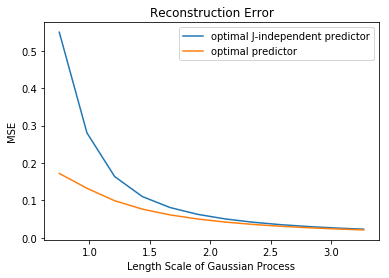

In [39]:
plt.plot(length_scales, results['0.5']['masked'], label = 'optimal J-independent predictor')
plt.plot(length_scales, results['0.5']['full'], label = 'optimal predictor')
#plt.plot(length_scales, np.repeat(0.25, len(length_scales)), label = 'noise level', color = 'k', linestyle = '--')

plt.xlabel('Length Scale of Gaussian Process')
plt.ylabel('MSE')
plt.title('Reconstruction Error')
plt.legend()
plt.savefig(dir + 'gaussian_mse.pdf')

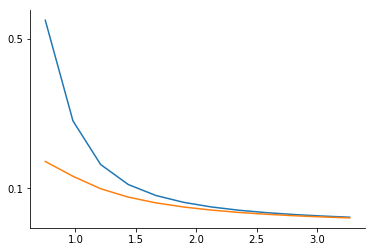

In [40]:
plt.plot(length_scales, results['0.5']['masked'], label = 'optimal J-independent predictor')
plt.plot(length_scales, results['0.5']['full'], label = 'optimal predictor')

plt.yticks([0.1, 0.5])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig(dir + 'gaussian_mse_bare.pdf')

As the length scale increases, both the absolute and relative reconstruction error for the masked data decreases.

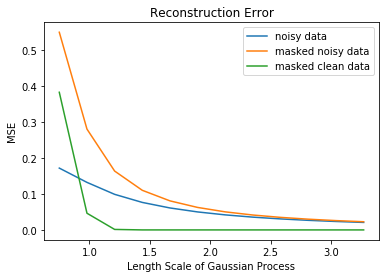

In [41]:
plt.plot(length_scales, results['0.5']['full'], label = 'noisy data')
plt.plot(length_scales, results['0.5']['masked'], label = 'masked noisy data')
plt.plot(length_scales, results['0.5']['gt_masked'], label = 'masked clean data')

plt.xlabel('Length Scale of Gaussian Process')
plt.ylabel('MSE')
plt.title('Reconstruction Error')
plt.legend()